In [20]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts import options as opts
from pyecharts.charts import Radar
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# Commonly used machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Import Data
profile=pd.read_json('profile.json',lines=True)
portfolio=pd.read_json('portfolio.json',lines=True)
transcript=pd.read_json('transcript.json',lines=True)

In [22]:
# Extract the value of the value item in the transaction order
transcript['value']=transcript['value'].map(lambda x:list(x.values())[0])

In [23]:
# Combine the three tables into one
temp_data=pd.merge(left=transcript,right=profile,left_on=['person'],right_on=['id'])
data=pd.merge(left=temp_data,right=portfolio,left_on=['value'],right_on=['id'],how='left')

In [24]:
# There is no coupon data if the event is transaction, because the data here is arranged according to time, here you only need to fill in the corresponding coupon data with the data in the previous row.
for column in ['reward','channels','difficulty','duration','offer_type','id_y']:
    data[column].fillna(method='ffill',inplace=True)

In [25]:
# Added new features, whether the user has viewed the coupon
data=data.sort_values(by=['person','id_y','time']) # Sort the data according to customer id, coupon id, and time
data['is_viewed']=data['event'].map({'offer received':0,'offer viewed':1})
data['is_viewed'].fillna(method='ffill',inplace=True) # Because it’s sorted, just fill it with the previous value.
data=data.dropna() # Remove missing values

In [26]:
# Filter out the transaction data. Here, because a customer can only use coupons once, we sort them according to customer id, coupon id, and event, so that for each coupon used by a customer, the offer completed event will be at the top, and then remove the duplicate
data=data[data['event'].isin(['transaction','offer completed'])]
data=data.sort_values(by=['person','id_y','event'])
data=data.drop_duplicates(subset=['person','id_y'])

In [27]:
data['web_channel']=data['channels'].map(lambda x:1 if 'web' in x else 0)
data['mobile_channel']=data['channels'].map(lambda x:1 if 'mobile' in x else 0)
data['social_channel']=data['channels'].map(lambda x:1 if 'social' in x else 0)

In [28]:
# Encode character variables and add new features
data['event']=data['event'].map({'transaction':0,'offer completed':1})
data['gender']=data['gender'].map({'O':0,'M':1,'F':2})
data['offer_type']=data['offer_type'].map({'informational':0,'discount':1,'bogo':2})
data['web_channel']=data['channels'].map(lambda x:1 if 'web' in x else 0)
data['mobile_channel']=data['channels'].map(lambda x:1 if 'mobile' in x else 0)
data['social_channel']=data['channels'].map(lambda x:1 if 'social' in x else 0)

In [29]:
# Remove the columns that are not needed
data=data.drop(columns=['value','id_x','id_y','person','channels'])

In [30]:
# Extract x, y, and divide the training set and test set according to the ratio of 1:4
data_x=data.drop(columns=['event'])
data_y=data['event']
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y,test_size=0.2,random_state=1)

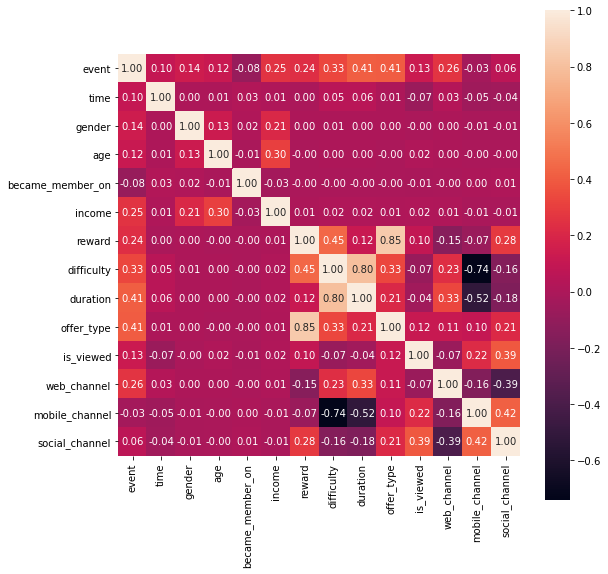

In [31]:
# Draw correlation matrix diagram
corr_data=data.corr()
plt.subplots(figsize=(9, 9))
sns.heatmap(corr_data, annot=True,square=True,fmt='.2f')
plt.show()

In [32]:
# Draw a radar chart
temp_data=data.copy()
x_columes=data_x.columns
scaler=MinMaxScaler()
temp_data[x_columes]=scaler.fit_transform(temp_data[x_columes])
radar_data=temp_data.groupby(by=['event']).mean().T

In [33]:
radar=(
    Radar()
    .add_schema(# Add schema
        schema=[
            opts.RadarIndicatorItem(name=name,min_=0,max_=1) for name in radar_data.index
        ]
    )
    .add('offer completed',radar_data[1].values.reshape(1,-1).tolist()) # If the schema has several indicators, the first few values will be taken by default
    .set_global_opts(title_opts=opts.TitleOpts(title='Radar chart'),)
)
radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) #Whether to tag
radar.render()

'/Users/gloria/Desktop/render.html'

The accuracy of the KNN model is: 0.627511427660253, and the AUC score is: 0.6267293230852976


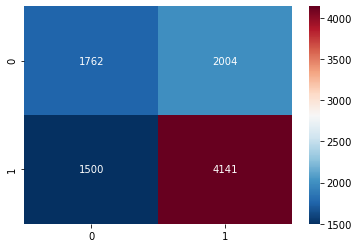

In [34]:
knn = KNeighborsClassifier(n_jobs=-1)                              # Build KNN model
knn.fit(X_train, y_train)                                         # Training model
y_prob = knn.predict_proba(X_test)[:, 1]                          # Predict the probability of category 1
y_pred = knn.predict(X_test)                                     # The model's prediction results on the test set
fpr_knn, tpr_knn, threshod_knn = metrics.roc_curve(
    y_test, y_prob)   # Get true positive rate, false positive rate, threshold
score_knn = metrics.accuracy_score(y_test, y_pred)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
print('The accuracy of the KNN model is: {0}, and the AUC score is: {1}'.format(score_knn, auc_knn))
print('============================================================')
cm=metrics.confusion_matrix(y_test, y_pred) # Plot the confusion matrix
sns.heatmap(cm,annot=True,fmt='g',cmap='RdBu_r')
plt.show()

The accuracy of the decision tree model is: 0.7766556819389816, and the AUC score is: 0.7699088392274036


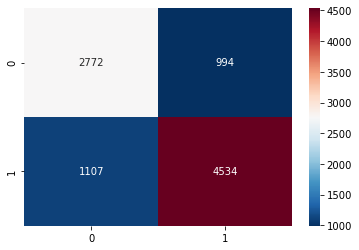

In [35]:
dtc = DecisionTreeClassifier()                              # Build a decision tree model
dtc.fit(X_train, y_train)                                         # Training model
y_prob = dtc.predict_proba(X_test)[:, 1]                          # Predict the probability of category 1
y_pred = dtc.predict(X_test)                                     # The model's prediction results on the test set
fpr_dtc, tpr_dtc, threshod_dtc = metrics.roc_curve(
    y_test, y_prob)   # Get true positive rate, false positive rate, threshold
score_dtc = metrics.accuracy_score(y_test, y_pred)
auc_dtc = metrics.auc(fpr_dtc, tpr_dtc)
print('The accuracy of the decision tree model is: {0}, and the AUC score is: {1}'.format(score_dtc, auc_dtc))
print('============================================================')
cm=metrics.confusion_matrix(y_test, y_pred)# Plot the confusion matrix
sns.heatmap(cm,annot=True,fmt='g',cmap='RdBu_r')
plt.show()

The accuracy of the logistic regression model is: 0.6325077070266822, and the AUC score is: 0.6491118953741587


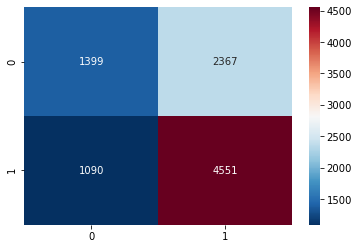

In [36]:
lr = LogisticRegression()                           # Instantiate an LR model
lr.fit(X_train, y_train)                                          # Training model
y_prob = lr.predict_proba(X_test)[:, 1]                           # Predict the probability of category 1
y_pred = lr.predict(X_test)                                      # The model's prediction results on the test set
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(
    y_test, y_prob)    # Get true positive rate, false positive rate, threshold
auc_lr = metrics.auc(fpr_lr, tpr_lr)                              # AUC score
score_lr = metrics.accuracy_score(y_test, y_pred)                 # Model accuracy
print('The accuracy of the logistic regression model is: {0}, and the AUC score is: {1}'.format(score_lr, auc_lr))
print('============================================================')
cm=metrics.confusion_matrix(y_test, y_pred) # Plot the confusion matrix
sns.heatmap(cm,annot=True,fmt='g',cmap='RdBu_r')
plt.show()

The accuracy of the random forest model is: 0.8273626023174232, and the AUC score is: 0.9062420477569061


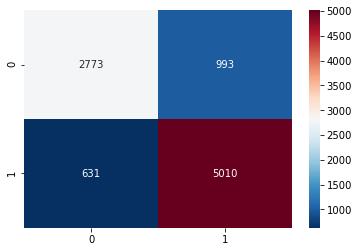

In [39]:
# Build a random forest classifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_train, y_train)                                           # Train a random forest model
y_prob = rfc.predict_proba(X_test)[:, 1]                            # Predict the probability of category 1
# The model's prediction results on the test set
y_pred = rfc.predict(X_test)
fpr_rfc, tpr_rfc, threshold_rfc = metrics.roc_curve(
    y_test, y_prob)   # Get true positive rate, false positive rate, threshold
auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)                             # AUC score
score_rfc = metrics.accuracy_score(y_test, y_pred)                  # Model accuracy
print('The accuracy of the random forest model is: {0}, and the AUC score is: {1}'.format(score_rfc, auc_rfc))
print('============================================================')
cm=metrics.confusion_matrix(y_test, y_pred) # Plot the confusion matrix
sns.heatmap(cm,annot=True,fmt='g',cmap='RdBu_r')
plt.show()

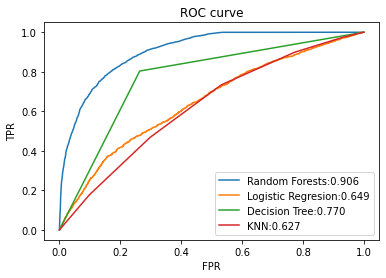

In [40]:
# Show ROC curve
plt.plot(fpr_rfc,tpr_rfc,label='Random Forests:{0:.3f}'.format(auc_rfc))         # Random Forests
plt.plot(fpr_lr,tpr_lr,label='Logistic Regresion:{0:.3f}'.format(auc_lr))         # Logistic Regresion
plt.plot(fpr_dtc,tpr_dtc,label='Decision Tree:{0:.3f}'.format(auc_dtc))         # Decision Tree
plt.plot(fpr_knn,tpr_knn,label='KNN:{0:.3f}'.format(auc_knn))         # KNN
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

plt.show()

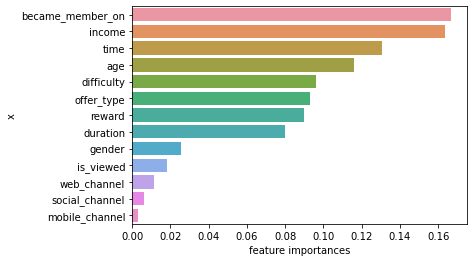

In [21]:
# Show the importance of random forest features
fi = pd.DataFrame(
    {"feature importances": rfc.feature_importances_, 'x': X_train.columns})
fi = fi.sort_values(by='feature importances', ascending=False)
sns.barplot(data=fi, x='feature importances', y='x')
plt.show()

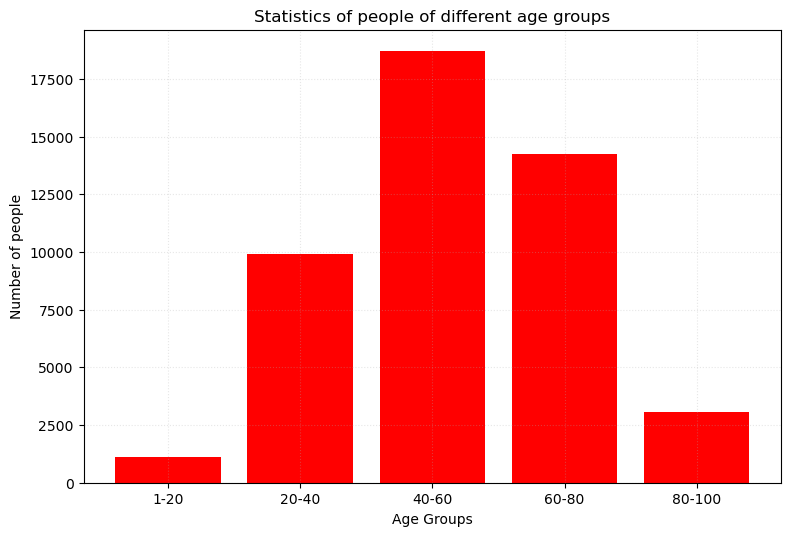

In [41]:
# All of the following are the generation of some simple statistical charts

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

df = pd.read_csv('data.csv', encoding='gbk')
age_group = ["1-20", "20-40", "40-60", "60-80", "80-100"]

count_1 = df[(df['age'] >= 1) & (df['age'] <= 20)]
count_2 = df[(df['age'] >= 21) & (df['age'] <= 40)]
count_3 = df[(df['age'] >= 41) & (df['age'] <= 60)]
count_4 = df[(df['age'] >= 61) & (df['age'] <= 80)]
count_5 = df[(df['age'] >= 81) & (df['age'] <= 100)]
age_counts = [len(count_1), len(count_2), len(count_3), len(count_4), len(count_5)]

# Set size and pixels
plt.figure(figsize=(9, 6), dpi=100)
# Draw a column chart, set the width and color of the column
plt.bar(age_group, age_counts, color='red')
# Add description information
plt.title('Statistics of people of different age groups')
plt.xlabel('Age Groups')
plt.ylabel('Number of people')
# Set the grid, transparency and line style
plt.grid(alpha=0.3, linestyle=':')
# Show picture
plt.show()

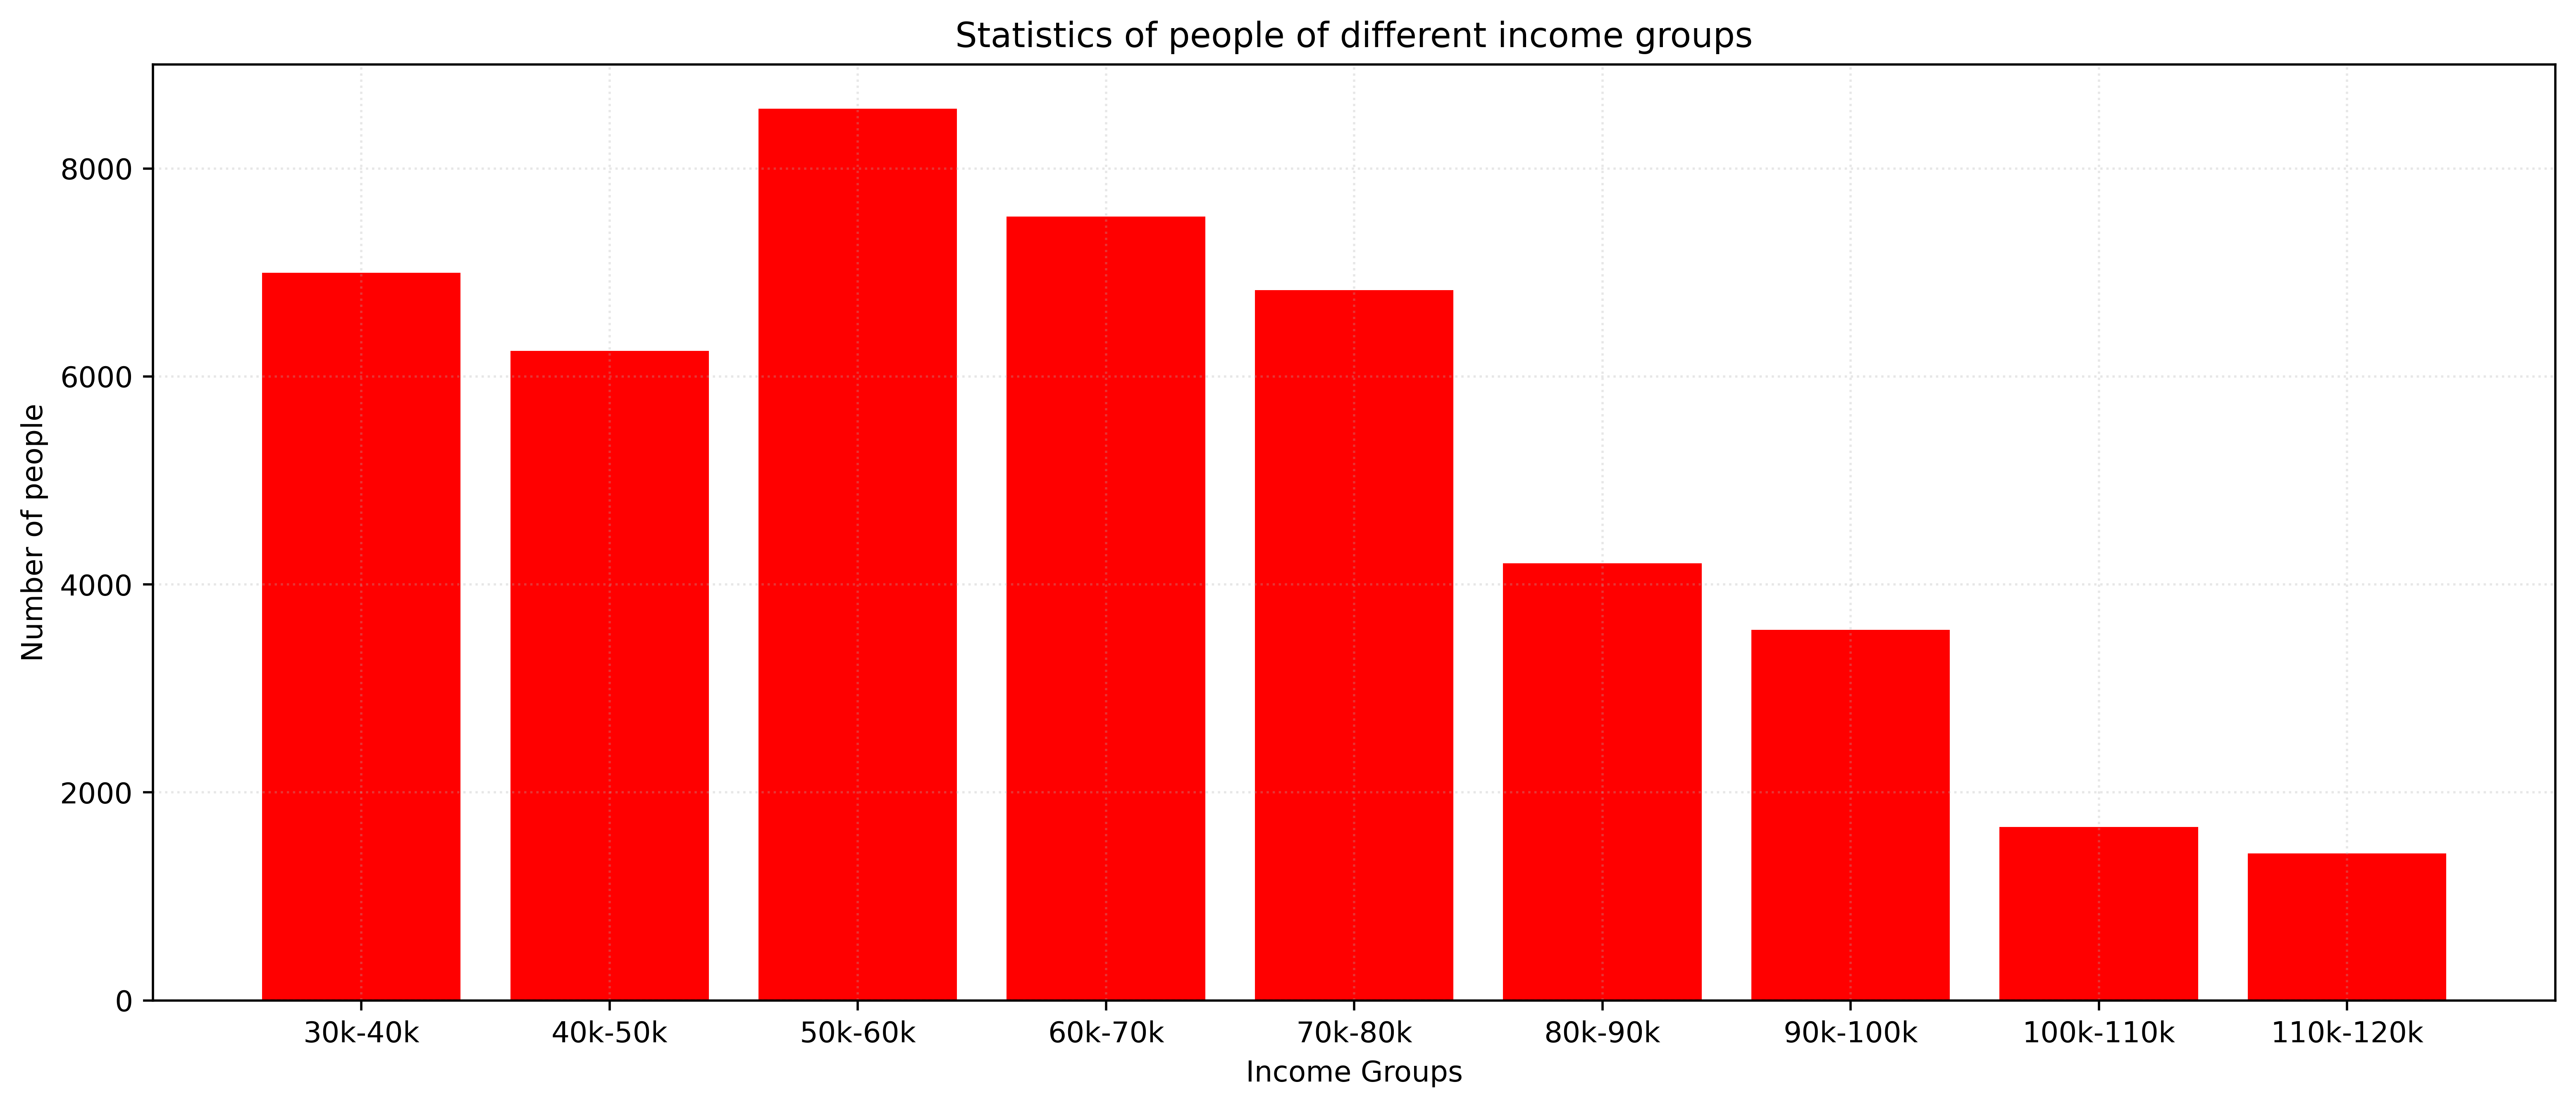

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


df = pd.read_csv('data.csv', encoding='gbk')

income_group = ["30k-40k", "40k-50k", "50k-60k", "60k-70k", "70k-80k", "80k-90k", "90k-100k", "100k-110k", "110k-120k"]

count_1 = df[(df['income'] >= 30000) & (df['income'] <= 40000)]
count_2 = df[(df['income'] >= 40001) & (df['income'] <= 50000)]
count_3 = df[(df['income'] >= 50001) & (df['income'] <= 60000)]
count_4 = df[(df['income'] >= 60001) & (df['income'] <= 70000)]
count_5 = df[(df['income'] >= 70001) & (df['income'] <= 80000)]
count_6 = df[(df['income'] >= 80001) & (df['income'] <= 90000)]
count_7 = df[(df['income'] >= 90001) & (df['income'] <= 100000)]
count_8 = df[(df['income'] >= 100001) & (df['income'] <= 110000)]
count_9 = df[(df['income'] >= 110001) & (df['income'] <= 120000)]
income_counts = [len(count_1), len(count_2), len(count_3), len(count_4), len(count_5), len(count_6), len(count_7), len(count_8), len(count_9)]

# Set size and pixels
plt.figure(figsize=(15, 6), dpi=500)
# Draw a column chart, set the width and color of the column
plt.bar(income_group, income_counts, color='red')
# Add description information
plt.title('Statistics of people of different income groups')
plt.xlabel('Income Groups')
plt.ylabel('Number of people')
# Set the grid, transparency and line style
plt.grid(alpha=0.3, linestyle=':')
# Show picture
plt.show()

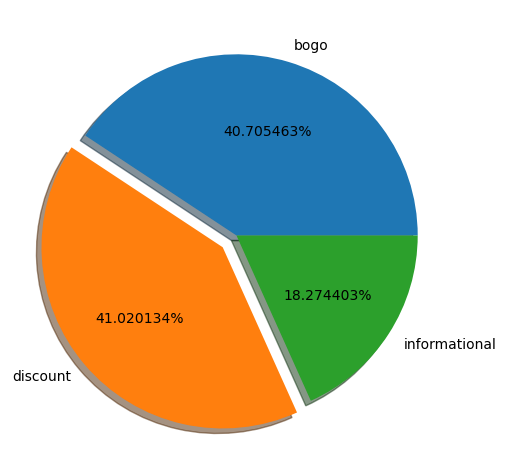

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


df = pd.read_csv('data.csv', encoding='gbk')
offer_type_group = ["bogo", "discount", "informational"]

count_1 = df[(df['offer_type'] == "bogo")]
count_2 = df[(df['offer_type'] == "discount")]
count_3 = df[(df['offer_type'] == "informational")]
offer_type_counts = [len(count_1), len(count_2), len(count_3)]

plt.figure(figsize=(9, 6), dpi=100)
plt.axes(aspect=1)
explode = [0,0.1,0]
plt.pie(x=offer_type_counts,labels=offer_type_group,autopct='%0f%%',explode= explode, shadow=True)
plt.show()


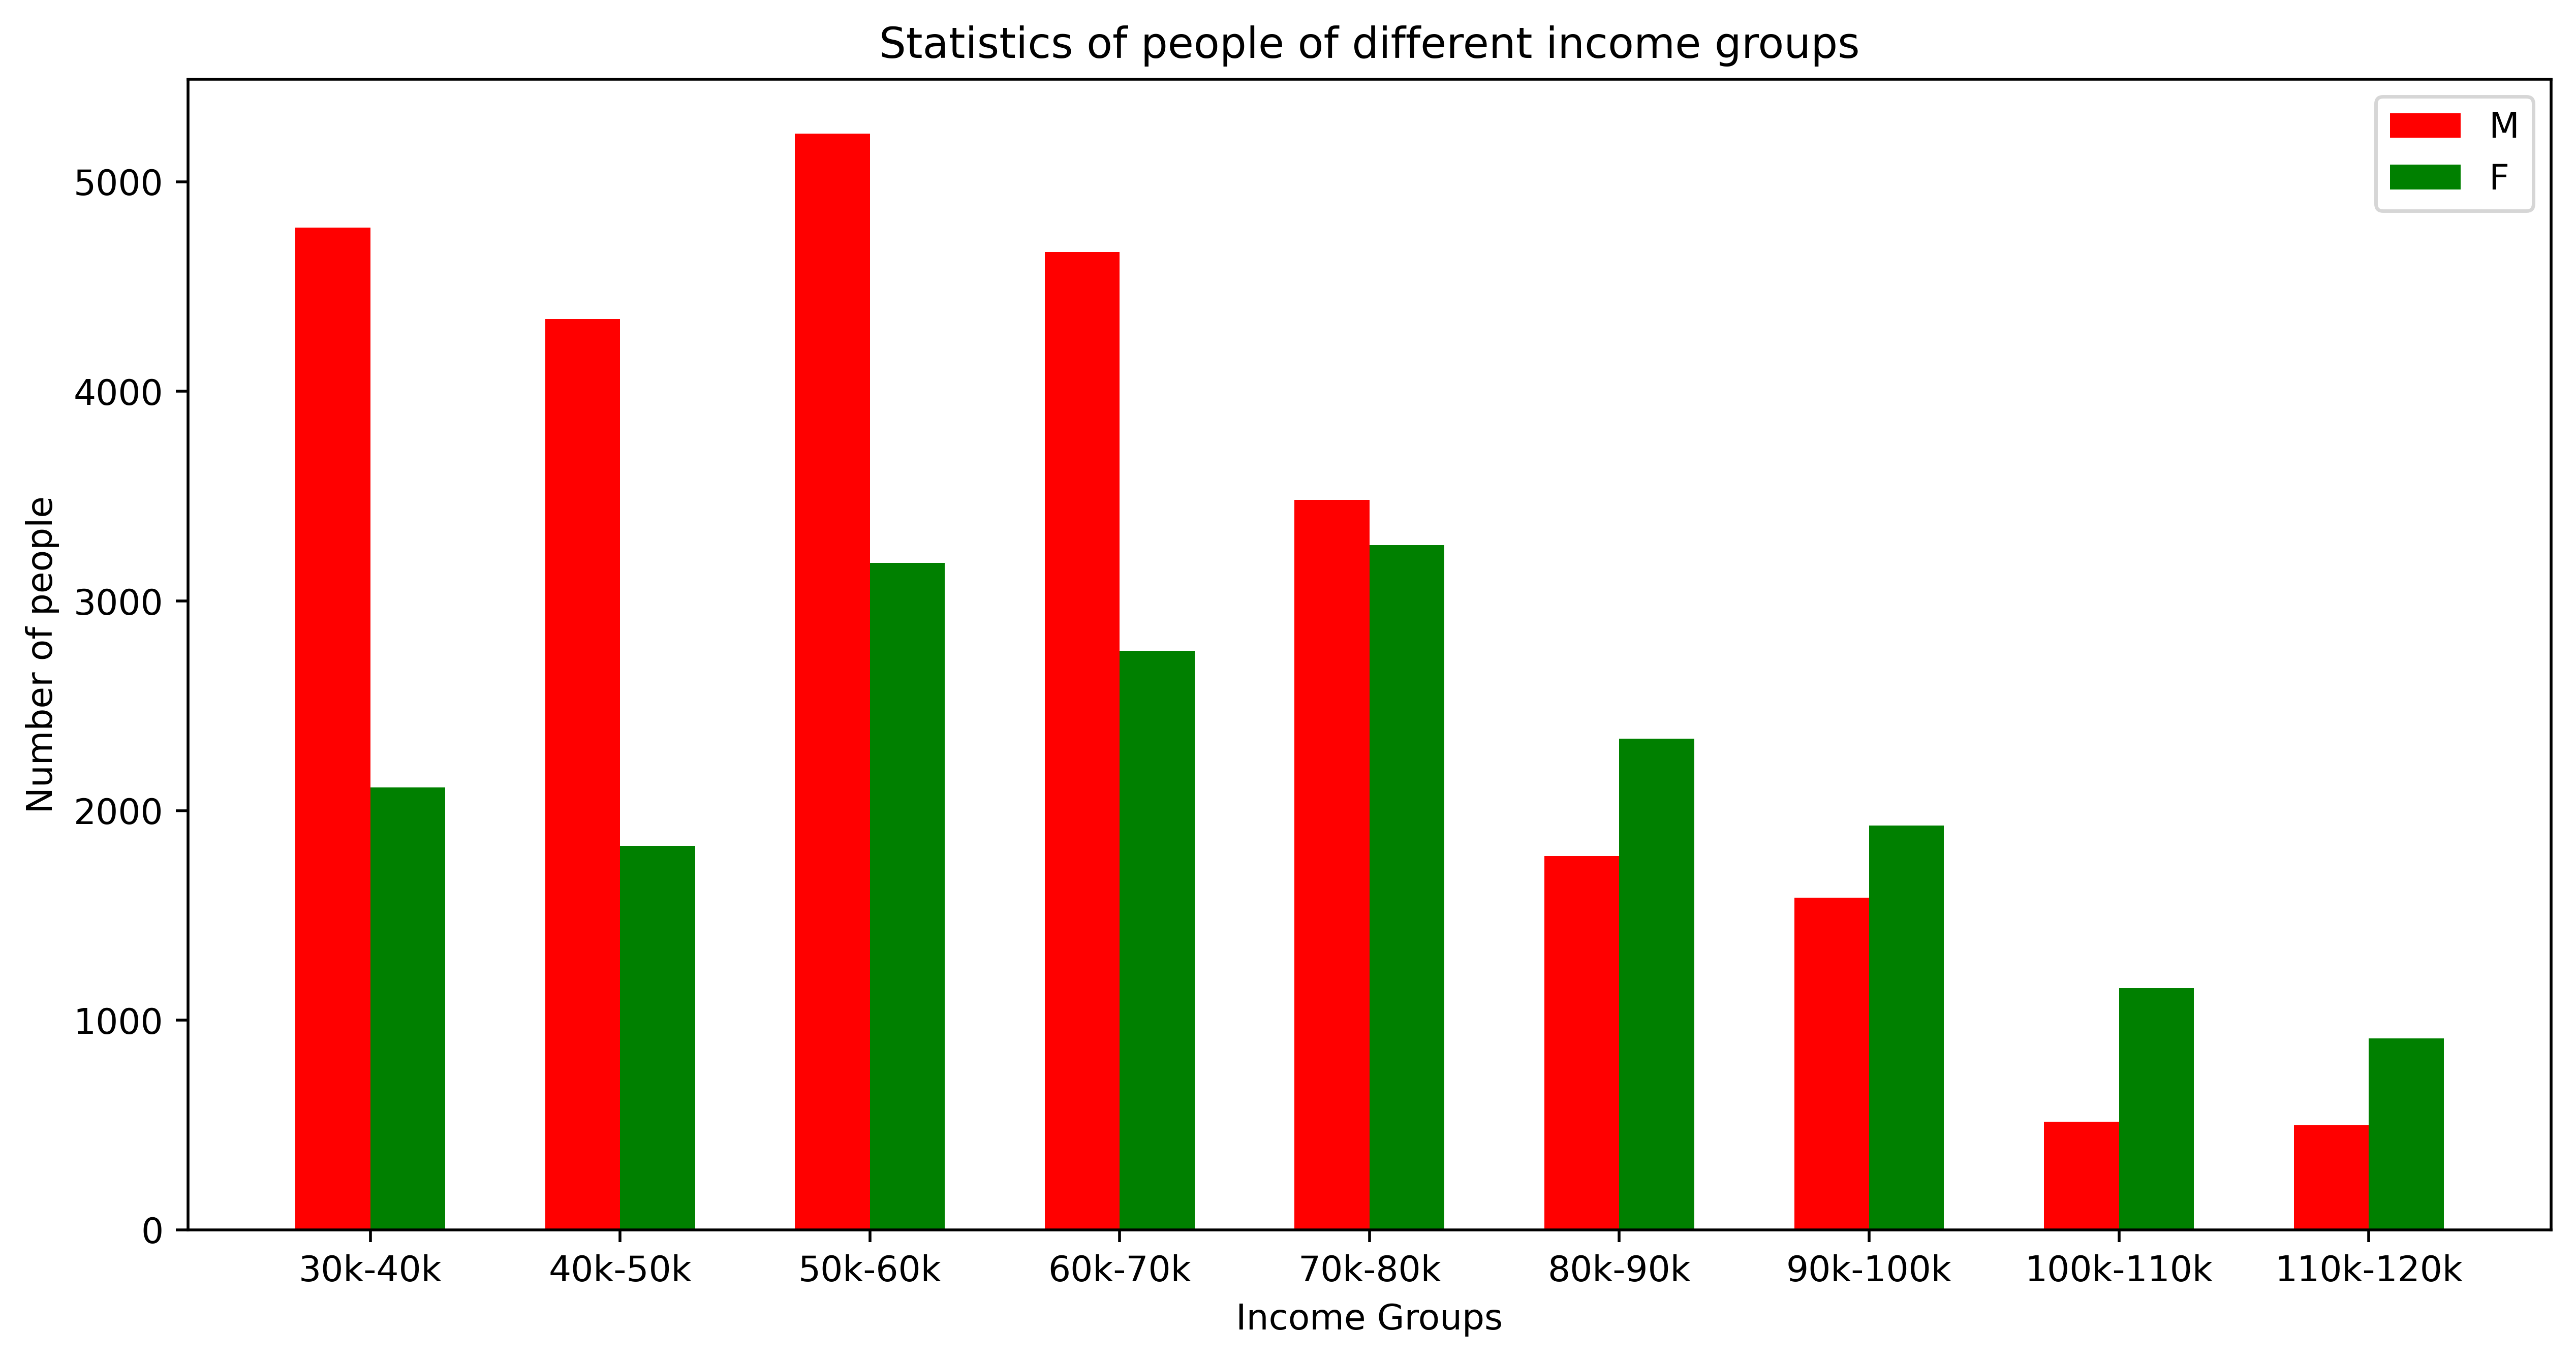

In [46]:
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('data.csv', encoding='gbk')
plt.figure(figsize=(12,6),dpi=500) #Create graphics

income_group = ["30k-40k", "40k-50k", "50k-60k", "60k-70k", "70k-80k", "80k-90k", "90k-100k", "100k-110k", "110k-120k"]

m_count_1 = df[(df['income'] >= 30000) & (df['income'] <= 40000) &(df['gender'] == "M")]
m_count_2 = df[(df['income'] >= 40001) & (df['income'] <= 50000) &(df['gender'] == "M")]
m_count_3 = df[(df['income'] >= 50001) & (df['income'] <= 60000) &(df['gender'] == "M")]
m_count_4 = df[(df['income'] >= 60001) & (df['income'] <= 70000) &(df['gender'] == "M")]
m_count_5 = df[(df['income'] >= 70001) & (df['income'] <= 80000) &(df['gender'] == "M")]
m_count_6 = df[(df['income'] >= 80001) & (df['income'] <= 90000) &(df['gender'] == "M")]
m_count_7 = df[(df['income'] >= 90001) & (df['income'] <= 100000) &(df['gender'] == "M")]
m_count_8 = df[(df['income'] >= 100001) & (df['income'] <= 110000) &(df['gender'] == "M")]
m_count_9 = df[(df['income'] >= 110001) & (df['income'] <= 120000) &(df['gender'] == "M")]
m_income_counts = [len(m_count_1), len(m_count_2), len(m_count_3), len(m_count_4), len(m_count_5), len(m_count_6), len(m_count_7), len(m_count_8), len(m_count_9)]

f_count_1 = df[(df['income'] >= 30000) & (df['income'] <= 40000) &(df['gender'] == "F")]
f_count_2 = df[(df['income'] >= 40001) & (df['income'] <= 50000) &(df['gender'] == "F")]
f_count_3 = df[(df['income'] >= 50001) & (df['income'] <= 60000) &(df['gender'] == "F")]
f_count_4 = df[(df['income'] >= 60001) & (df['income'] <= 70000) &(df['gender'] == "F")]
f_count_5 = df[(df['income'] >= 70001) & (df['income'] <= 80000) &(df['gender'] == "F")]
f_count_6 = df[(df['income'] >= 80001) & (df['income'] <= 90000) &(df['gender'] == "F")]
f_count_7 = df[(df['income'] >= 90001) & (df['income'] <= 100000) &(df['gender'] == "F")]
f_count_8 = df[(df['income'] >= 100001) & (df['income'] <= 110000) &(df['gender'] == "F")]
f_count_9 = df[(df['income'] >= 110001) & (df['income'] <= 120000) &(df['gender'] == "F")]
f_income_counts = [len(f_count_1), len(f_count_2), len(f_count_3), len(f_count_4), len(f_count_5), len(f_count_6), len(f_count_7), len(f_count_8), len(f_count_9)]

index=np.arange(9)
bw=0.3
plt.bar(index,m_income_counts,bw,color='r',label="M")
plt.bar(index+bw,f_income_counts,bw,color='g',label="F")
plt.xticks(index+0.5*bw,income_group)
plt.title('Statistics of people of different income groups')
plt.xlabel('Income Groups')
plt.ylabel('Number of people')
plt.legend()            #Set legend
plt.show()